## NBA Home Court Advantage

### Part 2: A Deeper Look at Win Percentages

In the [first notebook in this series on NBA home court advantage](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/nba_home_court-part1.ipynb), we saw that home court win percentages varied over the past 21 seasons, but have averaged around 60%.

In this notebook, we'll try to drill a little deeper into the distribution of home court win percentages.

Within a given NBA season, teams vary enormously in quality. From the historical data, we know that an average team (with a 50% win percentage) has roughly a 10% improvement in win probability from playing at home. But what about low-quality teams or elite teams? What does home court advantage look like for teams that aren't average?

Let's look at the data and see. We'll use the same matchup data from the 1996-97 through 2016-17 regular seasons.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.3f}'.format

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [3]:
from pathlib import Path

In [4]:
PROJECT_DIR = Path.cwd().parent / 'basketball' / 'nba'
DATA_DIR = PROJECT_DIR / 'data' / 'prepared'
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [5]:
def load_nba_historical_matchups(input_dir):
    """Load pickle file of NBA matchups prepared for analytics."""
    PKLFILENAME = 'stats_nba_com-matchups-1996_97-2016_17.pkl'
    pklfile = input_dir.joinpath(PKLFILENAME)
    return pd.read_pickle(pklfile)

In [6]:
matchups = load_nba_historical_matchups(DATA_DIR)
matchups.shape

(26787, 41)

In [7]:
seasons = sorted(list(matchups['season'].unique()))
len(seasons)

21

In [8]:
def prepare_regular_season(matchups):
    df = matchups.copy()
    df = df[df['season_type'] == 'regular']
    return df

In [9]:
reg = prepare_regular_season(matchups)
reg.shape

(24797, 41)

In [10]:
teams = sorted(list(reg['team_curr_h'].unique()))
len(teams)

30

### Grouping by Season and Team

Let's group the matchup information by season and team so we can look for patterns. To do this, we'll use the `pandas` [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) methods. These methods are very powerful but can be tricky to use correctly.

Grouping will allow us to calculate aggregate statistics for a particular team in a particular season. Teams change over time, as rosters, coaches and management evolve. Of course, there's also variation in team lineups intra-season, due to trades and injuries. We will eventually get to the player level of detail, but for now we will focus on the regular season as a reasonable time unit for analysizing a team.

We will also split the home and away games in this grouping. We can subtract the away game statistics from the home game statistics, controlling for season and team. This will allow us to develop a purer estimate of the impact of home court.

For now, we're only going to compute win percentages. In future analysis, we'll apply the same idea to box scores.

In [11]:
def win_loss_information(matchups, seasons, teams):
    # Split home and away games
    home_games = matchups.groupby(['season', 'team_curr_h', 'won'])
    away_games = matchups.groupby(['season', 'team_curr_a', 'won'])
    # Get counts of each type of game within each group
    home_wl_count = home_games['date'].count()
    away_wl_count = away_games['date'].count()
    # Get counts of home wins, home losses, away wins and away losses
    home_wins = {}
    home_losses = {}
    for season, team, winner in home_games.groups.keys():
        if winner == 'H':
            home_wins[(season, team)] = home_wl_count[(season, team, winner)]
        else:
            home_losses[(season, team)] = home_wl_count[(season, team, winner)]
    away_wins = {}
    away_losses = {}
    for season, team, winner in away_games.groups.keys():
        if winner == 'A':
            away_wins[(season, team)] = away_wl_count[(season, team, winner)]
        else:
            away_losses[(season, team)] = away_wl_count[(season, team, winner)]
    # Create DataFrame of counts and win/loss percentages
    df = pd.DataFrame({
        'home_wins': home_wins,
        'home_losses': home_losses,
        'away_wins': away_wins,
        'away_losses': away_losses,
    })
    df['home_games'] = df['home_wins'] + df['home_losses']
    df['away_games'] = df['away_wins'] + df['away_losses']
    df['games'] = df['home_games'] + df['away_games']
    df['wins'] = df['away_wins'] + df['home_wins']
    df['losses'] = df['away_losses'] + df['home_losses']
    df['win_percentage'] = df['wins'] / df['games']
    df['home_win_percentage'] = df['home_wins'] / df['home_games']
    df['away_win_percentage'] = df['away_wins'] / df['away_games']
    df = df.reset_index().rename(columns={'level_0': 'season', 'level_1': 'team'})
    return df[[
        'season',
        'team',
        'games',
        'wins',
        'losses',
        'win_percentage',
        'home_games',
        'home_wins',
        'home_losses',
        'home_win_percentage',
        'away_games',
        'away_wins',
        'away_losses',
        'away_win_percentage',
    ]]

In [12]:
wl = win_loss_information(reg, seasons, teams)
wl.head()

,season,team,games,wins,losses,win_percentage,home_games,home_wins,home_losses,home_win_percentage,away_games,away_wins,away_losses,away_win_percentage
0,1996-97,ATL,82,56,26,0.683,41,36,5,0.878,41,20,21,0.488
1,1996-97,BKN,82,26,56,0.317,41,16,25,0.390,41,10,31,0.244
2,1996-97,BOS,82,15,67,0.183,41,11,30,0.268,41,4,37,0.098
3,1996-97,CHI,82,69,13,0.841,41,39,2,0.951,41,30,11,0.732
4,1996-97,CLE,82,42,40,0.512,41,25,16,0.610,41,17,24,0.415


We now have data for season-by-season win percentages (overall, home and away) for each NBA team. As a reminder, we are using the current NBA team name for historical data, to keep track of team moves and name changes. Please see [the original post on scraping the data](http://practicallypredictable.com/2017/12/21/web-scraping-nba-team-matchups-box-scores/) for more information.

Since it took some work to create this view of the data, let's save it to a CSV file. That way, we can easily use the data in different analyses.

In [13]:
csvfile = DATA_DIR.joinpath('stats_nba_com-team_records-1996_97-2016_17.csv')
wl.to_csv(csvfile, index=False, float_format='%g')

### Analyzing the Win Percentages

Now let's get a high level overview of the win percentage and home win percentage, for each team/season pair.

In [14]:
hca = wl[['season', 'team', 'win_percentage', 'home_win_percentage']].copy()
hca.describe()

,win_percentage,home_win_percentage
count,622.000,622.000
mean,0.500,0.598
std,0.155,0.170
min,0.106,0.121
25%,0.390,0.488
50%,0.512,0.610
75%,0.610,0.732
max,0.890,0.976


There are 622 distinct team/season pairs. For some of these 21 seasons, there were only 29 NBA teams (prior to the Charlotte expansion).

As required by basic arithmetic, the average NBA team has a 50% win percentage. And we see the same 59.8% home team win percentage from our prior analysis. What's interesting in this table, though, is the distribution information.

For example, we see that the win percentage has ranged from just over 10% to as high as 89%, and that 50% of the win percentages are between 39% and 61%. To see that, look at the "25%" and "75%" rows in table above. This table shows the [quartiles](https://en.wikipedia.org/wiki/Quartile) of the win percentage distribution. Quartiles are a particular example of [quantiles](https://en.wikipedia.org/wiki/Quantile).

The 25% and 75% quantiles of the home win percentage distribution are roughly 49% and 73%. These also happen to be roughly 10% higher than the corresponding win percentage. So, how correct is it to simply add 10% to any NBA team's win percentage to predict their home win percentage? Or conversely, how correct is it to subtract 10% from any NBA team's home win percentage to predict their overall season win percentage?

Before we answer that question, let's look at how these percentages vary over time, by season.

### Variation by Season

For simplicity, we'll just look at the average win percentage and home win percentage by season. You could also do this analysis with the [median](https://en.wikipedia.org/wiki/Median) (the 50% quantile) or some other statistic.

In [15]:
hca.groupby('season')['home_win_percentage', 'win_percentage'].mean()

,home_win_percentage,win_percentage
season,,
1996-97,0.575,0.500
1997-98,0.595,0.500
1998-99,0.623,0.500
1999-00,0.611,0.500
2000-01,0.598,0.500
2001-02,0.591,0.500
2002-03,0.628,0.500
2003-04,0.614,0.500
2004-05,0.605,0.500


The average win percentage isn't too interesting, since it's always 50%. The home win percentage fluctuates by season as we saw in our [preliminary analysis](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/nba_home_court-part1.ipynb).

### Ranking by Quartile

Let's make this analysis a little more interesting. Let's organize the data by quartile, so we can see if there is any useful pattern for weak, mediocre, good and elite teams.

We can use `pandas` to get the numerical values of each quartile.

In [16]:
hca_ranks = hca.groupby('season').rank(numeric_only=True, pct=True)
hca_ranks.head()

,home_win_percentage,win_percentage
0,0.931,0.776
1,0.241,0.241
2,0.086,0.069
3,1.000,1.000
4,0.534,0.552


Now, all we need to do is to label our data with the quartile number. For every team/season win percentage and home win percentage, we can just look up in the above table what quartile that team is for that season.

Fortunately, `pandas` lets us do this in just a few lines of Python.

In [17]:
def quartile_index(x):
    return pd.qcut(x, q=4, labels=False)

In [18]:
def get_quartiles(df):
    df_q = df.groupby('season').rank(numeric_only=True, pct=True).apply(quartile_index)
    for col in df_q.columns:
        df[col].astype(int)
    return df_q

In [19]:
get_quartiles(hca).head()

,home_win_percentage,win_percentage
0,3,3
1,0,0
2,0,0
3,3,3
4,2,2


Let's take a moment to reflect on the above example. What we did was apply a function (to look up the quartile number) to our original `DataFrame`, and create a new `DataFrame` with those quartile values instead of the original data. This table only displays the first 5 lines of the data set, which comprise 622 team/season pairs. Let's put all this in a function to return the full 622-row table.

In [20]:
def get_hca_quartile(hca, col, quartile):
    df = get_quartiles(hca)
    return df[df[col] == quartile]

### An Interesting Figure

Since a picture is worth a thousand words, let's make a picture. We can use different colors to signify the different quartiles. Let's see the `seaborn` color palette.

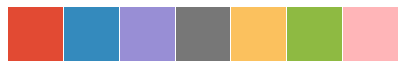

In [21]:
colors = sns.color_palette()
sns.palplot(colors)

We'll use the 4 colors on the right to signify the bottom, third, second and top quartile teams. We need a function to plot the data for each quartile in the correct color. We'll call this function 4 times, once for each quartile. The quartile is based on the team's win percentage in that season. The top quartile is the elite teams in that season, irrespective of home win percentage, and so on for the lower quartiles.

In [22]:
def plot_hca_quartile(ax, hca, x_col, y_col, quartile, label, colors):
    lookup_df = get_hca_quartile(hca, y_col, quartile)
    data_df = hca.loc[lookup_df.index, :]
    ax = sns.regplot(
        data=data_df, x=x_col, y=y_col, ax=ax, fit_reg=False,
        label=label,
        scatter_kws={'alpha': 0.5, 'facecolors': colors[6-quartile]}
    )
    return ax

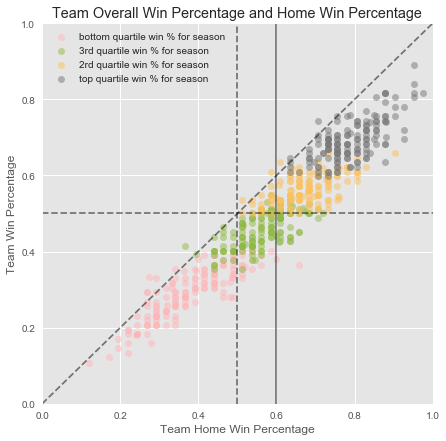

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
x_col = 'home_win_percentage'
y_col = 'win_percentage'
ax = plot_hca_quartile(ax, hca, x_col, y_col, 0, 'bottom quartile win % for season', colors)
ax = plot_hca_quartile(ax, hca, x_col, y_col, 1, '3rd quartile win % for season', colors)
ax = plot_hca_quartile(ax, hca, x_col, y_col, 2, '2rd quartile win % for season', colors)
ax = plot_hca_quartile(ax, hca, x_col, y_col, 3, 'top quartile win % for season', colors)
ax.set_xlim(0, 1)
ax.set_xlabel('Team Home Win Percentage')
ax.set_ylim(0, 1)
ax.set_ylabel('Team Win Percentage')
ax.set_title('Team Overall Win Percentage and Home Win Percentage')
ax.legend()
ax.plot(ax.get_xlim(), ax.get_ylim(), linestyle='--', color='black', alpha=0.5)
ax.axhline(y=0.5, linestyle='--', alpha=0.5, color='black')
ax.axvline(x=0.5, linestyle='--', alpha=0.5, color='black')
ax.axvline(x=hca['home_win_percentage'].mean(), alpha=0.5, color='black')
plt.show()

The figure has 4 lines overlaid to help in the interpretation.

The horizontal dashed line divides the plot into team/season pairs with overall winning records in that season.

The vertical dashed line divides the plot into team/season pairs with better-than-even home win percentages in that season. As you would expect, most of the observations fall to the right of this vertical line.

There are some bottom-quartile teams with winning home records, and there are some third-quartile teams with losing home records.

As a curiousity, look at the team sticking out on the lower-right. This team had a better than 65% home win record, but was sub-40% overall. Who was it? The 2002-3 Chicago Bulls, with their [franchise-worst 3-38 road record](https://en.wikipedia.org/wiki/2002%E2%80%9303_Chicago_Bulls_season). They got 27 

In [24]:
wl.loc[
    (wl['win_percentage'] < 0.38) & (wl['home_win_percentage'] > 0.62),
    ['season', 'team', 'win_percentage', 'home_win_percentage', 'wins', 'losses']
]

,season,team,win_percentage,home_win_percentage,wins,losses
177,2002-03,CHI,0.366,0.659,30,52


The vertical solid line shows the location of the home win percentage average for all teams and seasons (59.8%).

The diagonal line has slope 1, and is where the team win percentage equals the home win percentage. In other words, _teams on this line had no observable home court advantage_ in that particular season.

In fact, we see that there are a few teams which had _worse_ home records than overall records. Here is a list of the 11 times where that occurred.

In [25]:
wl.loc[
    wl['win_percentage'] > wl['home_win_percentage'],
    ['season', 'team', 'win_percentage', 'home_win_percentage', 'wins', 'losses']
]

,season,team,win_percentage,home_win_percentage,wins,losses
14,1996-97,MIA,0.744,0.707,61,21
162,2001-02,NOP,0.537,0.512,44,38
272,2005-06,HOU,0.415,0.366,34,48
300,2006-07,DET,0.646,0.634,53,29
343,2007-08,ORL,0.634,0.610,52,30
369,2008-09,MIN,0.293,0.268,24,58
384,2009-10,BOS,0.610,0.585,50,32
404,2009-10,PHI,0.329,0.293,27,55
437,2010-11,SAC,0.293,0.268,24,58
443,2011-12,BKN,0.333,0.273,22,44


### Conclusion

There is clearly a strong association between a team's home win percentage and the team's overall win percentage. The 10% extra home win probability rule of thumb is reasonable for an average team. However, there is a lot of variation around the averages.

Moving along the horizontal line, we see that a team with an average win percentage could have anywhere from a below-average (50%) to a good (70%) home win percentage.

Similarly, moving along the dashed vertical line, we see that a team with a below-average 50% home win percentage could either have an average season (50% overall) or a very poor season.